<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/PODs_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 21st Century Planning Techniques for Creating Fire-Resilient Forests in the American West: Notebook
Author: John Hogland 2/8/2022

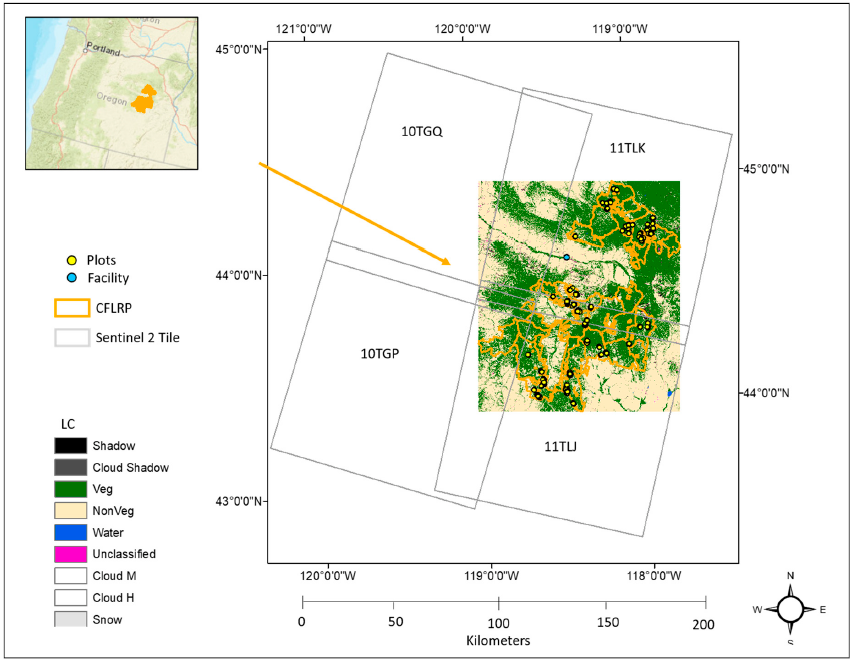


## Using PODs and raster_tools

In this notebook we will explore how we can use PODs to plan, budget, and monitor treatments designed to create fire resilient landscapes on 1.2 million ha in the Blue Mountains of OR. To demonstrate this approach we will be using the techniques and datasets created in [Hogland et. al. 2021](https://www.mdpi.com/1999-4907/12/8/1084).

note book requirements: 
- raster_tools - https://github.com/UM-RMRS/raster_tools.git

## Download the data and install raster_tools and mapclassify and upgrade gdown, numba, geopandas, and folium.
You can skip this step if you already installed raster_tools and upgraded gdown and numba within your environment. Don't forget to restart the runtime!

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install raster_tools

## Get the data and set raster_tools path
You can skip this step if you already have access to the data within your environment.

In [ ]:
import gdown, zipfile

url = r'https://drive.google.com/file/d/1zNYZRTgNEX4mNAtU1I3-7RD8VSo8-ATH/view?usp=sharing'
outfl= r'./BMFP_Notebook_data.zip'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

with zipfile.ZipFile(outfl, 'r') as zip_ref:
    zip_ref.extractall(".")


## The Data (data.gdb)
This database consists of Raster and Vector datasets that we will be using throughout the example:
- elevation (raster): elevation surface units meters
- MLC (raster): most likely class (0=nonforest, 1=pine, 2=fir)
- BAH (raster): basal area per hectare (band1=mean BAH, band2=standard error)
- tonne (raster): total tonne (band1=mean tonne, band2=standard error)
- stonne (raster): stem tonne (band1=mean stem tonne, band2=standard error)
- roads (vector): tiger roads
- streams (vector): NHD streams
- water bodies (vector): NHD water bodies
- facility (vector): location of the sawmill
- PODs (vector): potential operational delineations


## Base Raster and Vector Datasets 
Import raster_tools and modules, specify paths, and make vector and raster objects.

In [ ]:
#import raster_tools and modules 
from raster_tools import Raster, surface, distance, open_vectors, general, zonal, creation, Vector
import raster_tools
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

#specify paths to data layers
flgeodb = './data.gdb'
lyr_streams_path = 'streams'
lyr_pods_path = 'pods'
lyr_roads_path = 'roads'
lyr_facility_path = 'Facility'
lyr_waterbody_path = 'waterbodies'
rs_elv_path = './elevation.tif'
rs_mlc_path = './MLC.tif'
rs_bah_path = './BAH.tif'
rs_tonne_path = './tonne.tif'
rs_stonne_path = './stonne.tif'

#get the vectors and rasters objects
strms, pods, rds, fac, wtrbd = open_vectors(flgeodb,[lyr_streams_path,lyr_pods_path,lyr_roads_path,lyr_facility_path,lyr_waterbody_path])
#convert pods polygons to lines and buffer
pdbuff=Vector(gpd.GeoDataFrame(geometry=pods.data.compute().boundary.buffer(400))) #using eucidean distance 
#get rasters
mlc=Raster(rs_mlc_path)
elv=Raster(rs_elv_path).astype('int32') #need to convert to 32 bit depth and define null value
bah=Raster(rs_bah_path)
swbh=Raster(rs_stonne_path)
agbh=Raster(rs_tonne_path)

In [ ]:
# plot the data
p0=rds.data.compute().plot(color='dimgray',zorder=3, figsize=(15,15), linewidth=1)
p1=strms.data.compute().plot(ax=p0,color='deepskyblue',zorder=2,linewidth=0.5)
p2=fac.data.compute().plot(ax=p1,color='yellow',zorder=5,linewidth=10)
p3=pods.data.compute().plot(ax=p2,facecolor="none",edgecolor='orange',zorder=4,linewidth=2)
p3=elv.plot(ax=p3,robust=True,cmap=plt.cm.terrain,zorder=1)
p3

# The Process
1. Spatially define desired future condition (DFC)
2. Use DFC and existing BAH to quantify potential BAH removed
3. Convert % BAH removed to sawlog (ST) and biomass tonne (BT) removed
4. Spatially quantify potential cost of treatment
5. Find potential treatment units
6. Calculate cost & revenues of removal
7. Summarize potential treatment units by POD boundaries

## 1. Desired Future Condition (DFC)
To spatialy define DFC we will use an elevation raster, PODs Boundaries, stream side management zones (SMZs) and the criteria listed in Table 1. 

<div align="left"><b> Table1.</b> Desired basal area per ha (BAH) for the Pine an Fir dominant forest cover types. Processing order identifies the priority of desired BAH threshold, in shared areas, given the selection rule.</div>

|Description|Rule|Order|Desired BAH|
|:-|:-|:-|:-|
|MLC|<1|0|Existing|
|Slope|>50%|1|Existing|
|SMZ|Within 30 m|2|Existing|
|POD Boundary|Within 0.4 km|3|15 BAH|
|North Aspect|270-90 Azimuth|4|27 BAH|
|South Aspect|90-270 Azimuth|5|20 BAH|


In [ ]:
# mlc for pine and fir cover types
pinefir= mlc > 0

#slope use binary thresholding (0 or 1) to define deferred Lands
slp=surface.slope(elv,degrees=False) < 0.5

#SMZ using 3d surface distance (this will take longer than euclidean buffering [below] but will represent the surface distance
t1=Vector(strms.data[(strms.data['FCode'] == 55800) | (strms.data['FCode'] == 46006)]) #subset the streams data into major water ways (FCode 46006 or 55800)
r1=(t1.to_raster(elv, all_touched=True)>0).astype(int) #convert the subset of streams into a raster and select all stream cells rasterized
src=r1.set_null_value(0) #set null values for surface distance routine
c_rs=creation.constant_raster(elv.astype('float')).set_null_value(0) #create a cost raster of 1 so that only 3d distance will be calculated
d,t,a=distance.cost_distance_analysis(c_rs,src,elv) #run the cost distance analyses output will be distance (d), traceback (t), and allocation (a)
smz = d >= 30 #create a binary value of 1 for all accumulated distance greater than the SMZ width 30m, 0 otherwise

#WaterBodies using binary threholding( 0 or 1) to define deferred lands
wtr=(wtrbd.to_raster(elv,all_touched=False).set_null_value(None)) < 1 #reset mask and turn masked cell values to zero

#create mask
msk = (pinefir * slp * smz * wtr).astype('float')

#PODs
pods_buff = (pdbuff.to_raster(elv,all_touched=False).set_null_value(None) < 1) #convert vector buffered boundaries to a raster and reset mask and turn masked cell values (null) to zero

#Aspect
asp=surface.aspect(elv)
asp=asp.where(asp>0,0) #removing false values

nasp=((asp>270) | (asp<90)) * 27.0
sasp=((asp>=90) & (asp<=270)) * 20.0

#Combined to spatially define DFC
def_bah=(nasp+sasp)
dfc=(def_bah.where(pods_buff,15.0)).set_crs(def_bah.crs)

In [ ]:
p0=rds.data.compute().plot(color='dimgray',zorder=3, figsize=(15,15), linewidth=1)
p1=fac.data.compute().plot(ax=p0,color='yellow',zorder=3,linewidth=10)
dfc.plot(ax=p1,zorder=1,cmap=plt.cm.brg,levels=3,robust=True)

## 2. Potential BAH Removed ($\Delta$BAH)
Here we will quantify potential BAH removed using DFCs and the outputs described in [Hogland et. al. 2021](https://www.mdpi.com/1999-4907/12/8/1084) ($\Delta$BAH) from the landscape by subtracting our spatial DFCs from our existing conditions. Potential removals in this case are estimated only for cells that have delta BAH values significantly different than 0 at the 95% confidence level. 

In [ ]:
bah_m = bah.get_bands([1])
bah_se = bah.get_bands([2])
tr = bah_m-dfc
c1=bah_se * 1.96
c2=tr>c1
dbah=((tr.where(c2,0)*msk).set_null_value(0)).set_crs(c2.crs)

## 3. Convert % BAH removed to sawlog (ST) and biomass tonne (BT) removed
To convert $\Delta$BAH into stem wood biomass per hectare (SWBH) and total above ground biomass per hectare (AGBH) removed we will use the proportion of potential $\Delta$BAH being removed.

<p style=text-align:center>$\Delta$SWBH = $\frac{\Delta BAH}{BAH}$ * SWBH</p>

<p style=text-align:center>$\Delta$AGBH = $\frac{\Delta BAH}{BAH}$ * AGBH</p>


ST and BT are then calculated by incorporating % leakage and the spatial area of each raster cell (0.09 ha) where leakage is estimated at 5% for ST and 50% for BT.

<p style=text-align:center>ST = $\Delta$SWBH * (1-0.05) * 0.09</p>
<p style=text-align:center>BT = ($\Delta$AGBH - $\Delta$SWBH) * (1-0.5) * 0.09</p>

In [ ]:
pbah=dbah/bah_m
swbh_m=swbh.get_bands([1])
swbh_se=swbh.get_bands([2])
agbh_m=agbh.get_bands([1])
agbh_se=agbh.get_bands([2])
dswbh=pbah*swbh_m
dagbh=pbah*agbh_m
st=dswbh*0.95*0.09
bt=(dagbh-dswbh)*0.5*0.09

In [ ]:
p0=rds.data.compute().plot(color='dimgray',zorder=3, figsize=(15,15), linewidth=1)
p1=fac.data.compute().plot(ax=p0,color='yellow',zorder=3,linewidth=10)
dagbh.plot(ax=p1,zorder=1,robust=True)

## 4. Potential cost of treatment
Using the delivered cost algorithm described in [Hogland et. al. 2018](https://www.mdpi.com/2220-9964/7/4/156), we will quantify potential costs to harvest and move material from the landscape to a given facility using the rates in Table 2. To illustrate the delivered cost algorithm we will break the procedure into two subsections; **On Road Dollars Per Tonne** and **Total Dollars Per Tonne**.

**Table 2**. Cost components used to convert travel time into cost. Tonne mass units are presented as bone dry.

|Component|Type|Value|Units|
|:-:|:-:|:-:|:-:|
On-road|Machine Rate|90|Dollar/Hour|
||Speed|Table 3|KPH|
||Payload|25.40|Tonne|
|Off-road|Machine Rate|80|Dollar/hour|
||Speed|4.83|KPH|
||Payload|3.63|Tonne|
|Other|Harvesting & Processing|65|Dollar/tonne|
||Administrative|0|Dollar/Tonne|

**Table 3**. Road segment travel speed by tiger MTFCC class types.

|Query|Speed KPH|
|:-|:-:|
|MTFCC = “S1400”: Local Road, Rural Road, City Street|40|
MTFCC = “S1200”: Secondary road|56|
MTFCC = “S1100”: Primary road|88|
NOT (MTFCC = “S1400” OR MTFCC = “S1200” OR MTFCC = “S1100”)|40|



### On Road Dollars Per Tonne 

#### Converting the roads speed attribute into a cost raster surface that can be used to calculate dollars per tonne
Within the roads layer there is a KPH field. This field denotes how fast a log truck can travel down a given road segment. We will use the roads geodataframe and the KPH field to convert our vector based road network into a raster surface of dollars per tonne. 

To do this we will create a new field that converts speed to dollars per tonne and then convert the linear network into a raster surface that can be integrated into the accumulated path distance tool. The steps for this process are as follows:
1. Add a field to the roads table that changes speed (KPH) into dollars per tonne 
2. Convert the vector roads layer to a raster using the dollar per tonne field
3. Set zero values to null


#### Adding a dollar per tonne field
For step 1 we can save a great deal of processing by recognizing that we can convert surface distance (s_d) into round trip surface distance (rsd) along the roadway, measured in meters (elevation raster projection), to hours/tonne (hpt). To do this we can assume a log truck on average can carry **25.40** tonnes (bone dry) per load and with a little math we can convert our segment speeds into hours/tonne.

<p style=text-align:center>$rsd = 2 *s\_d$</p>

<p style=text-align:center>$h = rsd / (KPH*1000)$</p>

<p style=text-align:center>$hpt = h / 25.40$</p>


Moreover we can convert hpt to dollars per tonne (dt) by assuming a constant tractor trailer machine rate of **90** dollars per hour.

<p style=text-align:center>$dt=hpt*90$</p>

Using some basic table calculations we can create a our dollars per tonne field which can further be used within the cost distance tool as a cost surface to estimate an accumulated cost to move materials along the roadway. 

In [ ]:
#step 1
rds.data['dpt'] = 2*(1/(rds.data['Speed']*1000))/25.40*90 #dollars per tonne

#step 2
t1=rds.to_raster(elv.astype('float'),'dpt') #convert to raster dataset (note the new raster cell values correspond to the row from the geodataframe)

#step 3
roadrs=t1.set_null_value(0)

### Total Dollars Per Tonne
#### Calculating On Road Accumulated Dollars Per Tonne
Now that we have our roads rate surface of dollars per tonne per meter, we can use it (as a cost surface) in conjunction with a our facility location (sawmill) and elevation surface to calculate the least accumulated travel cost along the road way to the sawmill (zeros = null).      

#### Converting Surface Distance Into Cost Measured In Accumulated Dollars Per Tonne (on road)
Using our roadrs surface of log truck hailing speeds, a constant log truck payload of **25.40** bone dry tonnes (green 46), a machine rate of **90** dollars per hour, and the distance module (cost_distance_analysis function) within raster_tools, we will create accumulated dollars per tonne surface along the roadway. The cost_distance_analysis function takes costs, sources, and elevation surfaces as inputs to estimate the accumulated cost values for the least cost path. The steps to convert distance into costs are as follows:
1. Convert facilities to a raster (can have multiple facilities here)
2. Calculate on road costs 

In [ ]:
#step 1: convert facilities vector to raster and set zero to null
t1=fac.to_raster(elv.astype('float'))
facrs=t1.set_null_value(0)

#step 2: calculate on road costs
on_tt, on_tb, on_all=distance.cost_distance_analysis(roadrs,facrs,elv)

In [ ]:
p0=fac.data.compute().plot(figsize=(15,15),color='yellow',zorder=4,linewidth=10)
on_tt.plot(ax=p0,robust=True,cmap=plt.cm.RdYlGn_r,zorder=1)

#### Calculating off road costs and adding those costs to on road costs
To estimate travel costs from the forest to the roadways (skidding & yarding) we can use the same procedure we used to estimate the least accumulated cost to and along the roadway. Next, to allocate on road dollars per tonne to off road cells we can use off road surface allocation, on road dollar per tonne, and arithmetic analyses to estimate a total dollars per tonne at the cell level for the forested landscape. Using our on_tt surface of dollars per ton, a constant rate of travel of **4.83** KPH, a constant skidder payload of **3.63** bone dry tonnes (green 8), a machine rate of **80** dollars per hour, and the distance module (cost_distance_analysis function) within raster_tools, we will create accumulated dollars per tonne surface to the roadway. The cost_distance_analysis function takes costs, sources, and elevation surfaces as inputs to estimate the accumulated cost values for the least cost path. The steps to create off road costs and add those costs to on road costs are as follows:
1. Create inputs to the cost_distance analysis function
2. Calculate off road costs and allocate on road dollars/tonne (in cents) to off road cells
3. Convert cents to dollars
4. Add on and off road dollar per tonne surfaces to felling and processing dollar per tonne costs (\$65) to make optimal potential total cost (OPTC) surfaces

In [ ]:
#Step 1: create inputs
dt=(elv>0)*(2*(1/(4.83*1000))/3.63)*80 #creating a constant raster that converts distance to $\tonne

#need to make barriers from major waterbodies
#dt = dt * wtr

#need to set null to define barriers
dt=dt.set_null_value(0) #need to set null to define barriers 
on_tt_cents=(on_tt*100).astype('int') #cost_distance_analysis needs the source raster to be an int. Changed on_tt to cents 

#Step 2: calculate on and off road costs
off_tt, off_tb, off_all = distance.cost_distance_analysis(dt,on_tt_cents,elv.astype('float')) #run the cost distance

#Step 3: convert cents to dollars
on_tt_alc=off_all.astype('float')/100.0 #convert cents to dollars again

#Step 4: Add on road, off road, felling, and processing costs 
optc=off_tt+on_tt_alc+65 #65 is the composite dollar per tonne cost of felling and processing

In [ ]:
#plot costs
p0=rds.data.compute().plot(color='dimgray',zorder=3, figsize=(15,15), linewidth=1)
p1=strms.data.compute().plot(ax=p0,color='deepskyblue',zorder=2,linewidth=0.5)
p2=fac.data.compute().plot(ax=p1,color='yellow',zorder=4,linewidth=10)
optc.plot(ax=p0,robust=True,cmap=plt.cm.RdYlGn_r,zorder=1)

## Potential treatment units
Potential treatment units differ from potential removals in many ways. One important difference is that potential removals highlight differences between existing conditions and desired outcomes from the standpoint of BAH ($\Delta$BAH). For many reasons cells identified with positive $\Delta$BAH may not necessary define practical treatment units from an operations standpoint. To help prioritize and identify potential mechanical treatment units while separating various potential products, we will use $\Delta$AGB thresholds, spatially incorporate connectivity, and build in area thresholds.The steps to implement this process are as follows:

1. Build $\Delta$AGBH thresholds
2. Defining connectivity
3. Apply area thresholds (will need to build a new function)

#### The process
First, using $\Delta$AGB we can identify cells that have at least 3 tonne of above ground biomass (at the 95% confidence level).
<p style=text-align:center>pt1 = dagbh > (3 + (1.96 * agbh_se))</p>
Next, unique regions that connect with one another can be estimated using the region function and a rook neighborhood.
Finally, we can specify a minimal contiguous area of 5 hectares (56 cells) to identify potential treatment units (ptu). For this last step we will need to create a new function.

##### The new function
Our function will use numba to take a list of values and set cells that have that value to one. All other values will be set to zero. 

In [ ]:
#definitions for remap function using 
from functools import partial
from numba import jit, prange
import numpy as np
@jit(nopython=True,nogil=True) #decorator to numba for compiling to C
def _remap_values(x,rmvls):
    outx=np.zeros_like(x)
    rws,clms=x.shape
    for rw in prange(rws):
        for cl in prange(clms):
            vl = int(x[rw,cl])
            outx[rw,cl]= int(vl in rmvls)
    return outx

def select_values(rs,vl_arr):
    outrs=rs.copy()
    data=outrs.xdata.data
    func_remap_values=partial(_remap_values,rmvls=vl_arr) #partially assign parameter 
    #map our remap function to dask chunks for each band in the raster and reassign rasters to the xarray dataset
    for b in range(data.shape[0]):
        data[b] = data[b].map_blocks(func_remap_values,dtype=float, meta=np.array((), dtype=float)) #map block to address fast processing
    outrs.xdata.data = data
    return outrs

##### Processing the data

In [ ]:
# 1. dagbh thresholds
pt1 = (dagbh > (3+(1.96*agbh_se)))

# 2. defining connectivity
pt2 = general.regions(pt1,unique_values=[1]).set_null_value(1)
vls,cnts=np.unique(pt2.xdata.data.compute(),return_counts=True)

# 3. area thresholds
test = vls!=0
vls_s=vls[test]
cnts_s = cnts[test]
vls_g55 = vls_s[cnts_s>55]
ptu=select_values(pt2,vls_g55).set_null_value(0)

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
cmapb=ListedColormap(['white','green'])
p0=rds.data.compute().plot(color='dimgray',zorder=2, figsize=(15,15), linewidth=1)
p1=fac.data.compute().plot(ax=p0,color='yellow',zorder=3,linewidth=10)
p2=pods.data.compute().plot(ax=p1,facecolor="none",edgecolor='orange',zorder=4,linewidth=1.5)
ptu.plot(ax=p2,cmap=cmapb,add_colorbar=False,zorder=1)
print("Total number of unique regions = " + str(vls.shape[0]))
print("Total number of unique regions with more than 5 hectares in size = " + str(vls_g55.shape[0]))

## Calculate cost & revenues of removal
To estimate actual cost of prescription implementation (ACPI) we will use $\Delta$AGBH, the optimal potential total cost (OPTC) surfaces, and the area of each raster cell (0.09 ha) as follows:

<p style=text-align:center>ACIP = $\Delta$AGBH * 0.09 * OPTC</p>

Similarly, to estimate expected revenues (ER) we will use an average green moisture content of 94%, and gate prices of 55 (106.70) and 28 (54.32) dollars per green (bone dry) tonne for ST and BT surfaces, respectively.

<p style=text-align:center>ER Saw = ST * Gate Prices Saw</p>
<p style=text-align:center>ER Biomass = BT * Gate Prices Biomass</p>
<p style=text-align:center>ER = ER Saw + ER Biomass</p>

Finally profits are estimated at the cell level by subtracting ACIP from ER.
<p style=text-align:center>Profit = ER-ACIP</p>

In [ ]:
acip = (dagbh*0.09*optc)
acip = acip.where(acip>=0,0).set_crs(acip.crs) #where is used here to address seperate null values and plotting
er_saw = st * 106.70
er_bio = bt * 54.32
er = er_saw + er_bio
profit = er-acip

## Summarize treatment units by POD boundaries

In [ ]:
#subset values to treatment units
ptu_e= ptu.eval()
tonne_rm = (st+bt)*ptu_e
cost_rm =acip*ptu_e
profit_rm = profit*ptu_e
revenue_rm = er*ptu_e

#summarize values by pod
df_tonne = zonal.zonal_stats(pods,tonne_rm,["sum"]).compute()
df_cost = zonal.zonal_stats(pods,cost_rm,["sum"]).compute()
df_profit = zonal.zonal_stats(pods,profit_rm,["sum"]).compute()
df_revenue = zonal.zonal_stats(pods,revenue_rm,["sum"]).compute()

#aggregate pod types
pods_tbl=pods.data.compute()
pods_tbl['tonne']=df_tonne['sum']
pods_tbl['cost']=df_cost['sum']
pods_tbl['profit']=df_profit['sum']
pods_tbl['revenue']=df_revenue['sum']

## Visualize the Results

In [ ]:
#summarize by SRZ and create a bar chart (millions)
sum_srz=pods_tbl[['SRZ','tonne','cost','revenue','profit']].groupby('SRZ').sum()/1000000

#create bar charts
sum_srz.plot(kind='bar',ylabel='Millions',title='Estimated Dollars by PODs Management Strategy', figsize=(16,8))

# This ends the 21st Century Planning Techniques example.